In [1]:
!pip install pytorch-lightning segmentation-models-pytorch rasterio tacoreader torchmetrics seaborn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tacoreader
from datamodule import CoreDataModule
from model import UNet_CD_Sentinel_2
import metrics
from matplotlib.colors import ListedColormap, BoundaryNorm
import segmentation_models_pytorch as smp
import torch
from tqdm import tqdm


# Ler Datasets

In [3]:
dataset_l1c = tacoreader.load(["/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l1c.0000.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l1c.0001.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l1c.0002.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l1c.0003.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l1c.0004.part.taco",
                              ])
dataset_l1c = dataset_l1c[(dataset_l1c["label_type"] == "high") & (dataset_l1c["real_proj_shape"] == 509) & (dataset_l1c['tortilla:data_split'] == "test")]

dataset_l2a = tacoreader.load(["/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l2a.0000.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l2a.0001.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l2a.0002.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l2a.0003.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l2a.0004.part.taco",
                              "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-l2a.0005.part.taco"
                              ])
dataset_l2a = dataset_l2a[(dataset_l2a["label_type"] == "high") & (dataset_l2a["real_proj_shape"] == 509) & (dataset_l2a['tortilla:data_split'] == "test")]

dataset_extra = tacoreader.load(["/content/drive/MyDrive/taco_CloudSen12/cloudsen12-extra.0000.part.taco",
                                "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-extra.0001.part.taco",
                                "/content/drive/MyDrive/taco_CloudSen12/cloudsen12-extra.0002.part.taco"])
dataset_extra = dataset_extra[(dataset_extra["label_type"] == "high") & (dataset_extra["real_proj_shape"] == 509)]
dataset_extra = dataset_extra[dataset_extra['tortilla:id'].isin(dataset_l2a['tortilla:id'])]


# Calculando as Métricas dos Modelos Treinados com as Imagens Teste de 512x512

In [ ]:
model_l2a_allbands_efficientnet = "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_efficientnet-b1/epoch=35-train_loss=0.24-val_loss=0.25-trainHigh512.ckpt"
model_l2a_allbands_mobilenet = "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_mobilenet_v2/epoch=57-train_loss=0.26-val_loss=0.28-trainHigh512.ckpt"

model_l1c_allbands_efficientnet = "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_efficientnet-b1/epoch=52-train_loss=0.22-val_loss=0.24-trainHigh512.ckpt"
model_l1c_allbands_mobilenet = "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_mobilenet_v2/epoch=63-train_loss=0.23-val_loss=0.25-trainHigh512.ckpt"

model_l2a_4bands_efficientnet = "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_efficientnet-b1/epoch=45-train_loss=0.25-val_loss=0.27-trainHigh512.ckpt"
model_l2a_4bands_mobilenet = "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_mobilenet_v2/epoch=60-train_loss=0.26-val_loss=0.28-trainHigh512.ckpt"

model_l1c_4bands_efficientnet = "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_efficientnet-b1/epoch=43-train_loss=0.25-val_loss=0.26-trainHigh512.ckpt"
model_l1c_4bands_mobilenet = "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_mobilenet_v2/epoch=65-train_loss=0.26-val_loss=0.29-trainHigh512.ckpt"

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import rasterio

# Normalizar para exibição
def normalize(image):
  return ((image - image.min()) / (image.max() - image.min())*1.5).clip(0,1)

# Função para carregar imagens
def load_image_maks(path):
    with rasterio.open(path.read(0)) as src:
        image = src.read().astype(np.float32) / 10000  # Normaliza
    with rasterio.open(path.read(1)) as mask:
        mask_data = mask.read(1).astype(np.int64)
    return image, mask_data

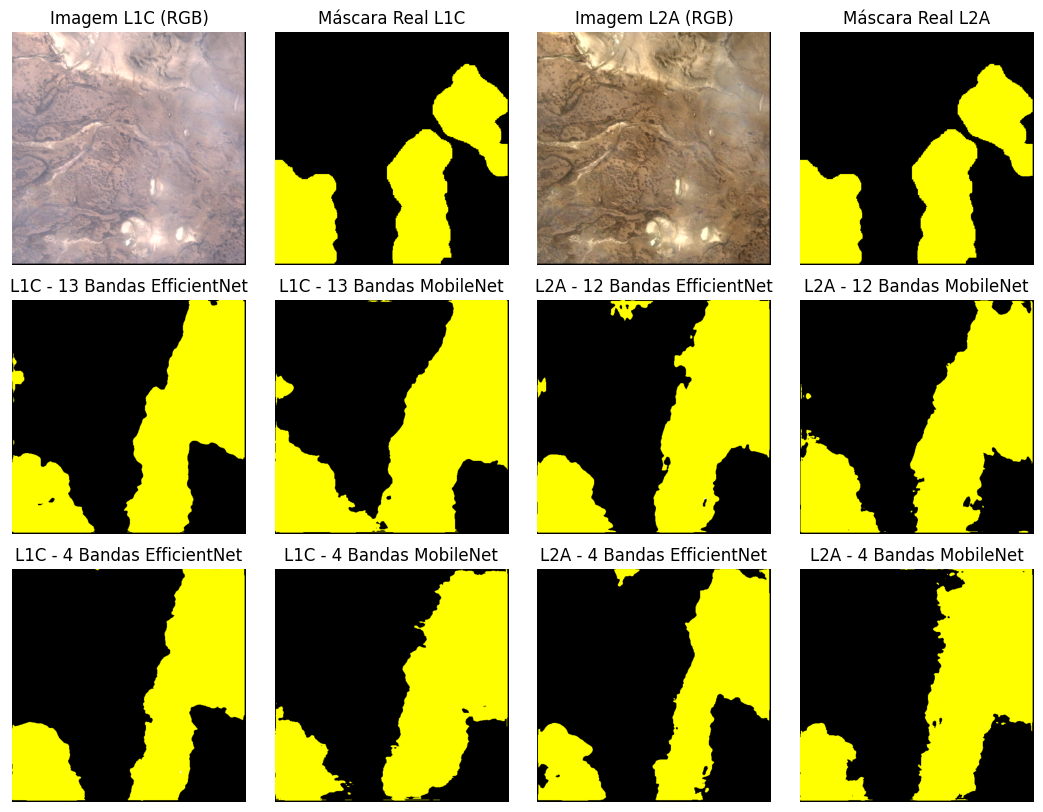

In [ ]:
# Função para carregar o modelo
def load_model(model_path):
    model = UNet_CD_Sentinel_2.load_from_checkpoint(model_path)
    model.eval()  # Modo avaliação
    return model

# Função para passar a imagem pelo modelo
def predict(model, image):
    device = next(model.parameters()).device
    with torch.no_grad():
        image_tensor = torch.from_numpy(image).unsqueeze(0).to(device)  # Adiciona batch
        #print(image_tensor.shape)
        prediction = model(image_tensor)
        pr_masks = torch.argmax(prediction, dim=1)

    return pr_masks.to('cpu').squeeze().numpy()

index = 0
path_l1c = dataset_l1c.read(index)
path_l2a = dataset_l2a.read(index)

# Carregar imagens L1C e L2A
image_l1c, mask_l1c = load_image_maks(path_l1c)
image_l2a, mask_l2a = load_image_maks(path_l2a)

# Definição dos modelos
models = {
    "L1C - 13 Bandas EfficientNet": load_model(model_l1c_allbands_efficientnet),
    "L1C - 13 Bandas MobileNet": load_model(model_l1c_allbands_mobilenet),
    "L2A - 12 Bandas EfficientNet": load_model(model_l2a_allbands_efficientnet),
    "L2A - 12 Bandas MobileNet": load_model(model_l2a_allbands_mobilenet),
    "L1C - 4 Bandas EfficientNet": load_model(model_l1c_4bands_efficientnet),
    "L1C - 4 Bandas MobileNet": load_model(model_l1c_4bands_mobilenet),
    "L2A - 4 Bandas EfficientNet": load_model(model_l2a_4bands_efficientnet),
    "L2A - 4 Bandas MobileNet": load_model(model_l2a_4bands_mobilenet),
}

# Selecionar bandas para cada tipo de modelo
all_bands_l1c = image_l1c
all_bands_l2a = image_l2a[[0,1,2,3,4,5,6,7,8,9,10,11], :, :]
four_bands = [1, 2, 3, 7]  # Índices das bandas 2,3,4,8 (convertido para 0-based index)

image_l1c_4bands = image_l1c[four_bands, :, :]
image_l2a_4bands = image_l2a[four_bands, :, :]

# Obter previsões dos modelos
predictions = {}
for name, model in models.items():
    if "L1C - 13 Bandas" in name:
        predictions[name] = predict(model, all_bands_l1c)
    elif "L2A - 12 Bandas" in name:
        predictions[name] = predict(model, all_bands_l2a)
    elif "L1C - 4 Bandas" in name:
        predictions[name] = predict(model, image_l1c_4bands)
    elif "L2A - 4 Bandas" in name:
        predictions[name] = predict(model, image_l2a_4bands)

# Definir as cores (valores de 0 a 3)
cores = ["black", "white", "yellow", "gray"]
cmap_custom = ListedColormap(cores)

# Criar uma normalização fixa para os valores 0, 1, 2, 3
norm = BoundaryNorm([0, 1, 2, 3, 4], cmap_custom.N)  # Define os intervalos das cores


def plot_results():
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))

    # Remove espaços entre os subplots para melhor aproveitamento do espaço
    plt.subplots_adjust(wspace=-0.3, hspace=0.15)

    # Plota imagens originais
    axes[0, 0].imshow(normalize(np.dstack([image_l1c[3], image_l1c[2], image_l1c[1]])))  # RGB falso L1C
    axes[0, 0].set_title("Imagem L1C (RGB)")

    axes[0, 2].imshow(normalize(np.dstack([image_l2a[3], image_l2a[2], image_l2a[1]])))  # RGB falso L2A
    axes[0, 2].set_title("Imagem L2A (RGB)")

    axes[0, 1].imshow(mask_l1c, cmap=cmap_custom, norm=norm)
    axes[0, 1].set_title("Máscara Real L1C")

    axes[0, 3].imshow(mask_l2a, cmap=cmap_custom, norm=norm)
    axes[0, 3].set_title("Máscara Real L2A")

    # Plota previsões
    for i, (name, pred) in enumerate(predictions.items()):
        row, col = divmod(i + 4, 4)
        axes[row, col].imshow(pred, cmap=cmap_custom, norm=norm)
        axes[row, col].set_title(name)

    # Removendo números dos eixos e bordas desnecessárias
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    # Salvando em alta resolução com bordas mínimas
    plt.savefig("comparação_modelos_treinados5.png", dpi=600, bbox_inches='tight')
    plt.show()


# Plotar tudo
plot_results()



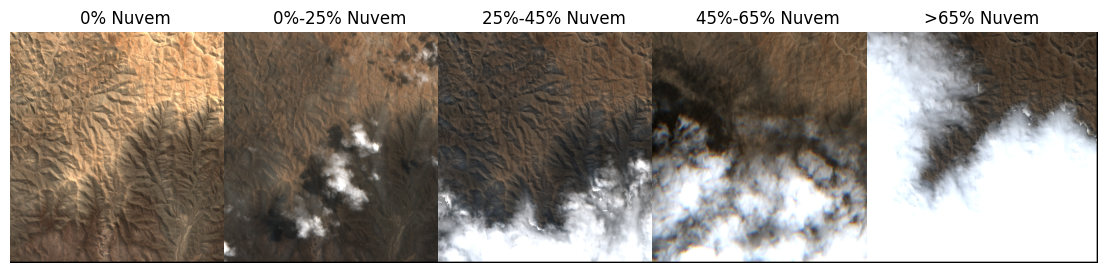

In [28]:
index = index #+ 5

path_l2a1 = dataset_l2a.read(index)
path_l2a2 = dataset_l2a.read(index+1)
path_l2a3 = dataset_l2a.read(index+2)
path_l2a4 = dataset_l2a.read(index+3)
path_l2a5 = dataset_l2a.read(index+4)
image_l2a1, _ = load_image_maks(path_l2a1)
image_l2a2, _ = load_image_maks(path_l2a2)
image_l2a3, _ = load_image_maks(path_l2a3)
image_l2a4, _ = load_image_maks(path_l2a4)
image_l2a5, _ = load_image_maks(path_l2a5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Remove espaços entre os subplots para melhor aproveitamento do espaço
plt.subplots_adjust(wspace=-0.3, hspace=0.15)

# Plota imagens originais
axes[0].imshow(normalize(np.dstack([image_l2a1[3], image_l2a1[2], image_l2a1[1]])))
axes[0].set_title("0% Nuvem")

axes[3].imshow(normalize(np.dstack([image_l2a2[3], image_l2a2[2], image_l2a2[1]])))
axes[3].set_title("45%-65% Nuvem")

axes[1].imshow(normalize(np.dstack([image_l2a3[3], image_l2a3[2], image_l2a3[1]])))
axes[1].set_title("0%-25% Nuvem")

axes[2].imshow(normalize(np.dstack([image_l2a4[3], image_l2a4[2], image_l2a4[1]])))
axes[2].set_title("25%-45% Nuvem")

axes[4].imshow(normalize(np.dstack([image_l2a5[3], image_l2a5[2], image_l2a5[1]])))
axes[4].set_title(">65% Nuvem")

# Removendo números dos eixos e bordas desnecessárias
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Salvando em alta resolução com bordas mínimas
plt.savefig("comparação_cobertura_nuvem.png", dpi=600, bbox_inches='tight')
plt.show()

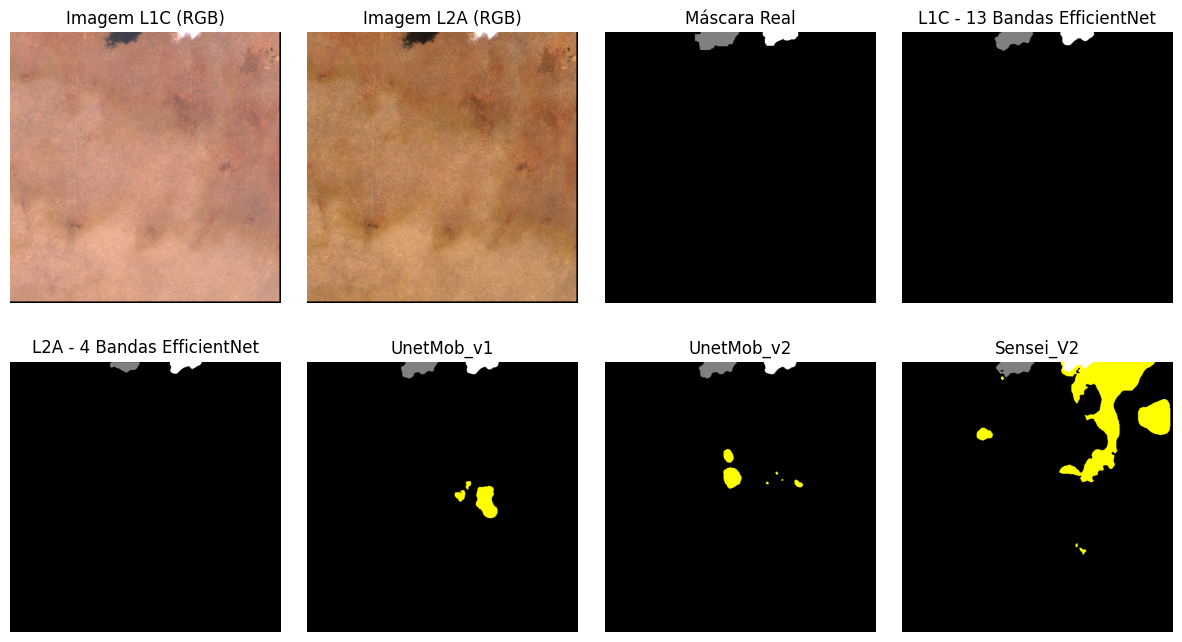

In [ ]:
index = index + 1
path_l1c = dataset_l1c.read(index)
path_l2a = dataset_l2a.read(index)

# Carregar imagens L1C e L2A
image_l1c, mask_l1c = load_image_maks(path_l1c)
image_l2a, mask_l2a = load_image_maks(path_l2a)

predict_l1c = predict(load_model(model_l1c_allbands_efficientnet), image_l1c)
predict_l2a = predict(load_model(model_l2a_4bands_efficientnet), image_l2a[[1,2,3,7], :, :])


s2_extra_sen2cor = dataset_extra.read(index).read(5)              # Sen2Cor by L2A.
s2_extra_unetmob_v1 = dataset_extra.read(index).read(9)           # Cloud mask generated by Aybar et al. 2022 model.
s2_extra_unetmob_v2 = dataset_extra.read(index).read(10)          # Cloud mask generated by Aybar et al. 2024 model.
s2_extra_sensei_v2 = dataset_extra.read(index).read(11)           # Cloud mask generated by Alistair Francis 2024.

with rasterio.open(s2_extra_sen2cor) as sen2cor:
    sen2cor_data = sen2cor.read(1)
    # Criando uma cópia dos dados para modificar
    transformed_data = np.zeros_like(sen2cor_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[sen2cor_data == 9] = 1
    transformed_data[sen2cor_data == 8] = 2
    transformed_data[sen2cor_data == 3] = 3
    sen2cor_data = transformed_data

with rasterio.open(s2_extra_unetmob_v1) as unetmob_v1:
    unetmob_v1_data = unetmob_v1.read(1)

with rasterio.open(s2_extra_unetmob_v2) as unetmob_v2:
    unetmob_v2_data = unetmob_v2.read(1)

with rasterio.open(s2_extra_sensei_v2) as sensei_v2:
    sensei_v2_data = sensei_v2.read(1)

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

# Remove espaços entre os subplots para melhor aproveitamento do espaço
plt.subplots_adjust(wspace=0.1, hspace=0.15)

axes[0, 0].imshow(normalize(np.dstack([image_l1c[3], image_l1c[2], image_l1c[1]])))  # RGB falso L2A
axes[0, 0].set_title("Imagem L1C (RGB)")

axes[0, 1].imshow(normalize(np.dstack([image_l2a[3], image_l2a[2], image_l2a[1]])))  # RGB falso L2A
axes[0, 1].set_title("Imagem L2A (RGB)")

axes[0, 2].imshow(mask_l2a, cmap=cmap_custom, norm=norm)
axes[0, 2].set_title("Máscara Real")

axes[0, 3].imshow(predict_l1c, cmap=cmap_custom, norm=norm)
axes[0, 3].set_title("L1C - 13 Bandas EfficientNet")

axes[1, 0].imshow(predict_l2a, cmap=cmap_custom, norm=norm)
axes[1, 0].set_title("L2A - 4 Bandas EfficientNet")

axes[1, 1].imshow(unetmob_v1_data, cmap=cmap_custom, norm=norm)
axes[1, 1].set_title("UnetMob_v1")

axes[1, 2].imshow(unetmob_v2_data, cmap=cmap_custom, norm=norm)
axes[1, 2].set_title("UnetMob_v2")

axes[1, 3].imshow(sensei_v2_data, cmap=cmap_custom, norm=norm)
axes[1, 3].set_title("Sensei_V2")

# Removendo números dos eixos e bordas desnecessárias
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Salvando em alta resolução com bordas mínimas
plt.savefig("comparação_modelos_mesma_classe8.png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
steps_outputs_metrics_sen2cor = []
steps_outputs_metrics_unetmob_v1 = []
steps_outputs_metrics_unetmob_v2 = []
steps_outputs_metrics_sensei_v2 = []
for index in tqdm(range(len(dataset_l2a)), desc="Calculando Métricas"):

  s2_l2a = dataset_l2a.read(index).read(0)
  s2_target = dataset_l2a.read(index).read(1)

  s2_extra_sen2cor = dataset_extra.read(index).read(5)              # Sen2Cor by L2A.
  s2_extra_unetmob_v1 = dataset_extra.read(index).read(9)           # Cloud mask generated by Aybar et al. 2022 model.
  s2_extra_unetmob_v2 = dataset_extra.read(index).read(10)          # Cloud mask generated by Aybar et al. 2024 model.
  s2_extra_sensei_v2 = dataset_extra.read(index).read(11)           # Cloud mask generated by Alistair Francis 2024.

  with rasterio.open(s2_target) as target:
      target_data = target.read(1)

  with rasterio.open(s2_extra_sen2cor) as sen2cor:
      sen2cor_data = sen2cor.read(1)

      # Criando uma cópia dos dados para modificar
      transformed_data = np.zeros_like(sen2cor_data)
      # Aplicando as transformações conforme solicitado
      transformed_data[sen2cor_data == 9] = 1
      transformed_data[sen2cor_data == 8] = 2
      transformed_data[sen2cor_data == 3] = 3
      sen2cor_data = transformed_data
      tp, fp, fn, tn = smp.metrics.get_stats(
            torch.from_numpy(sen2cor_data), torch.from_numpy(target_data), mode="multiclass", num_classes=4
        )
      steps_outputs_metrics_sen2cor.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})

  with rasterio.open(s2_extra_unetmob_v1) as unetmob_v1:
      unetmob_v1_data = unetmob_v1.read(1)
      tp, fp, fn, tn = smp.metrics.get_stats(
            torch.from_numpy(unetmob_v1_data), torch.from_numpy(target_data), mode="multiclass", num_classes=4
        )
      steps_outputs_metrics_unetmob_v1.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(s2_extra_unetmob_v2) as unetmob_v2:
      unetmob_v2_data = unetmob_v2.read(1)
      tp, fp, fn, tn = smp.metrics.get_stats(
            torch.from_numpy(unetmob_v2_data), torch.from_numpy(target_data), mode="multiclass", num_classes=4
        )
      steps_outputs_metrics_unetmob_v2.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(s2_extra_sensei_v2) as sensei_v2:
      sensei_v2_data = sensei_v2.read(1)
      tp, fp, fn, tn = smp.metrics.get_stats(
            torch.from_numpy(sensei_v2_data), torch.from_numpy(target_data), mode="multiclass", num_classes=4
        )
      steps_outputs_metrics_sensei_v2.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


Calculando Métricas: 100%|██████████| 975/975 [40:08<00:00,  2.47s/it]


In [ ]:
tp = torch.cat([x["tp"] for x in steps_outputs_metrics_sen2cor])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics_sen2cor])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics_sen2cor])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics_sen2cor])

acuracia_sen2cor = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou_sen2cor = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score_sen2cor = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

print(f"Acurácia no conjunto de teste: {acuracia_sen2cor:.4f}")
print(f"IoU no conjunto de teste: {iou_sen2cor:.4f}")
print(f"F1 no conjunto de teste: {f1_score_sen2cor:.4f}")

Acurácia no conjunto de teste: 0.8405
IoU no conjunto de teste: 0.5163
F1 no conjunto de teste: 0.6810


In [ ]:
tp = torch.cat([x["tp"] for x in steps_outputs_metrics_unetmob_v1])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics_unetmob_v1])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics_unetmob_v1])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics_unetmob_v1])

acuracia_unetmob_v1 = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou_unetmob_v1 = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score_unetmob_v1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

print(f"Acurácia no conjunto de teste: {acuracia_unetmob_v1:.4f}")
print(f"IoU no conjunto de teste: {iou_unetmob_v1:.4f}")
print(f"F1 no conjunto de teste: {f1_score_unetmob_v1:.4f}")

Acurácia no conjunto de teste: 0.9463
IoU no conjunto de teste: 0.8062
F1 no conjunto de teste: 0.8927


In [ ]:
tp = torch.cat([x["tp"] for x in steps_outputs_metrics_unetmob_v2])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics_unetmob_v2])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics_unetmob_v2])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics_unetmob_v2])

acuracia_unetmob_v2 = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou_unetmob_v2 = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score_unetmob_v2 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

print(f"Acurácia no conjunto de teste: {acuracia_unetmob_v2:.4f}")
print(f"IoU no conjunto de teste: {iou_unetmob_v2:.4f}")
print(f"F1 no conjunto de teste: {f1_score_unetmob_v2:.4f}")

Acurácia no conjunto de teste: 0.9483
IoU no conjunto de teste: 0.8127
F1 no conjunto de teste: 0.8967


In [ ]:
tp = torch.cat([x["tp"] for x in steps_outputs_metrics_sensei_v2])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics_sensei_v2])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics_sensei_v2])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics_sensei_v2])

acuracia_sensei_v2 = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou_sensei_v2 = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score_sensei_v2 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

print(f"Acurácia no conjunto de teste: {acuracia_sensei_v2:.4f}")
print(f"IoU no conjunto de teste: {iou_sensei_v2:.4f}")
print(f"F1 no conjunto de teste: {f1_score_sensei_v2:.4f}")

Acurácia no conjunto de teste: 0.9440
IoU no conjunto de teste: 0.7984
F1 no conjunto de teste: 0.8879


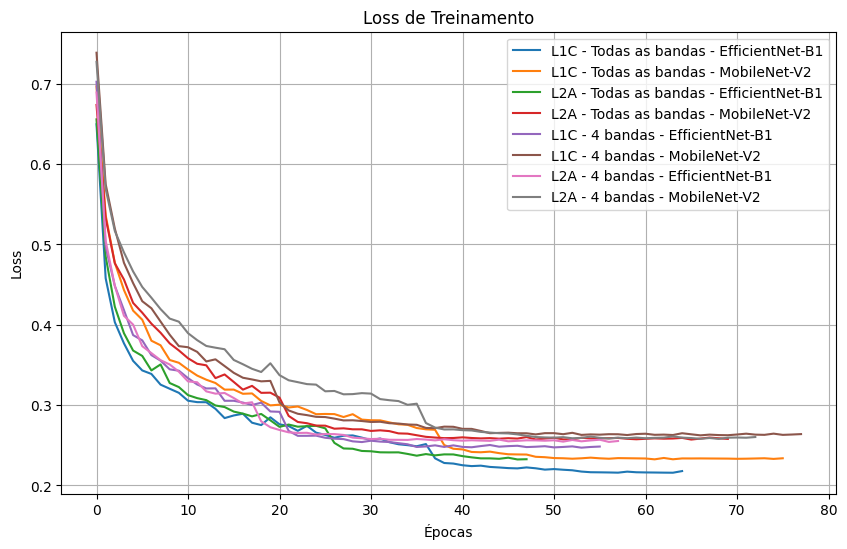

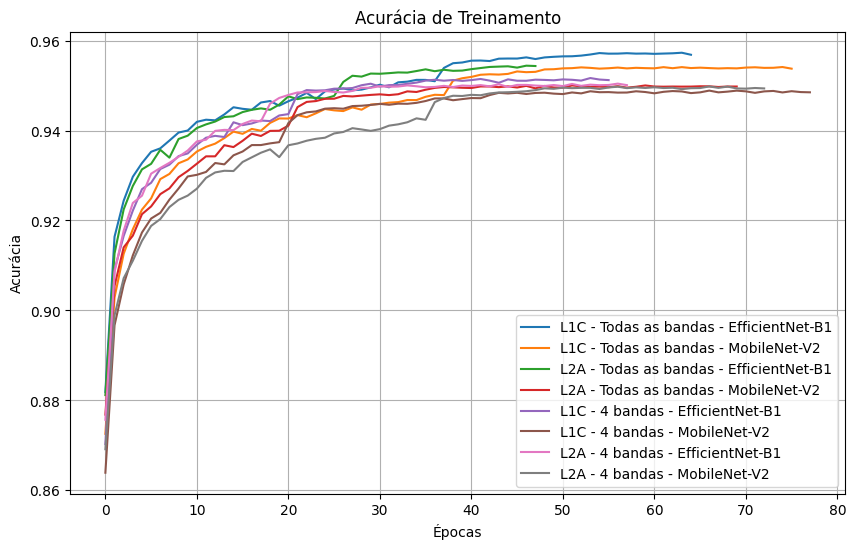

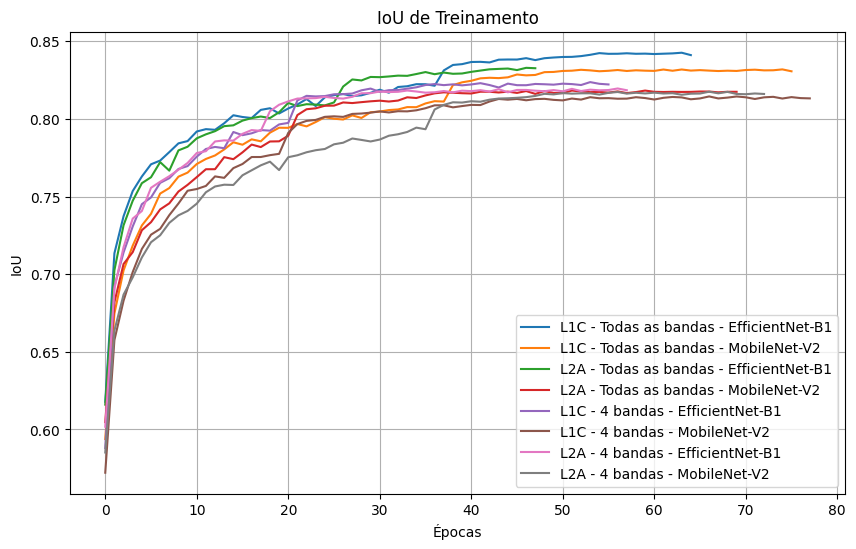

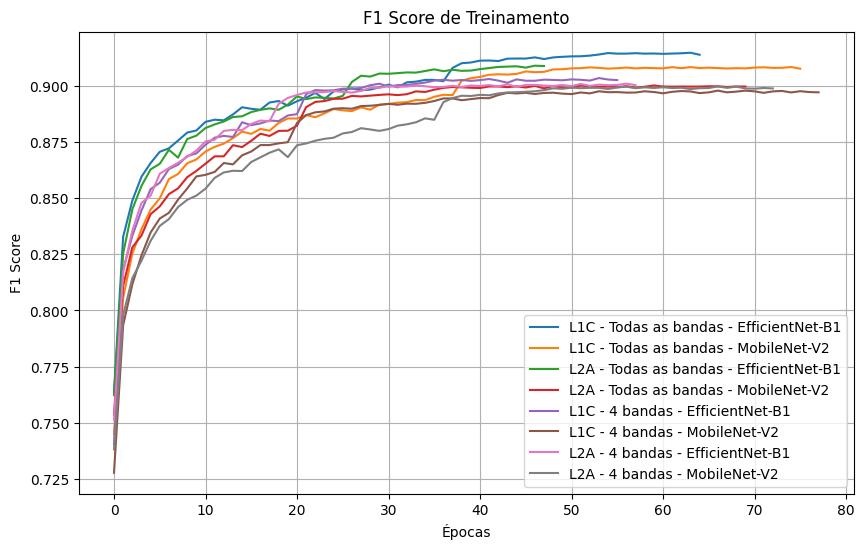

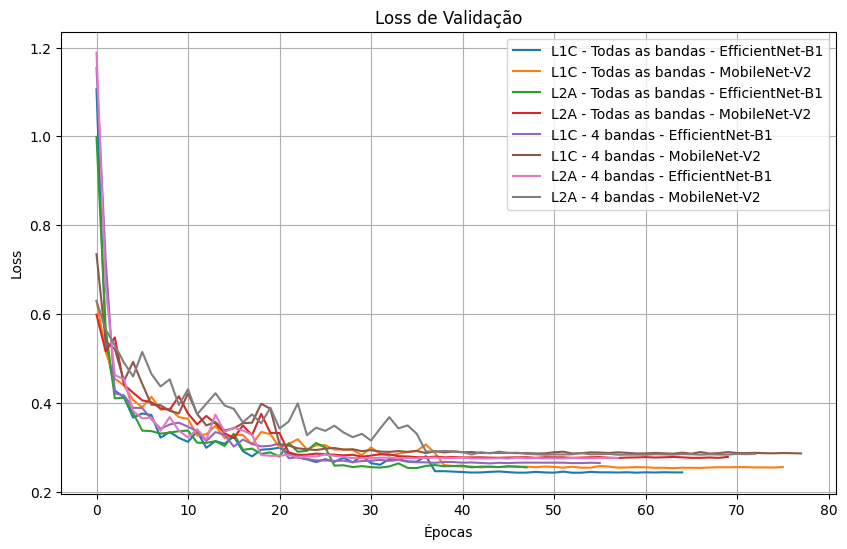

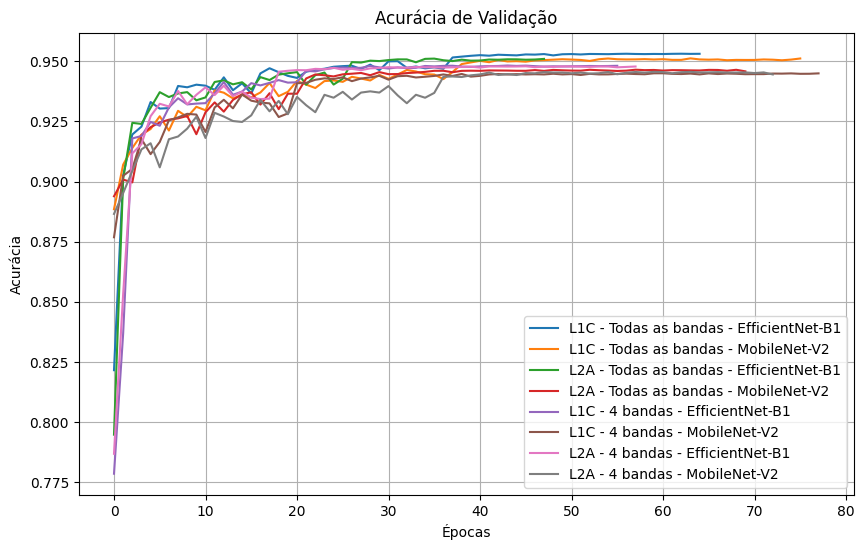

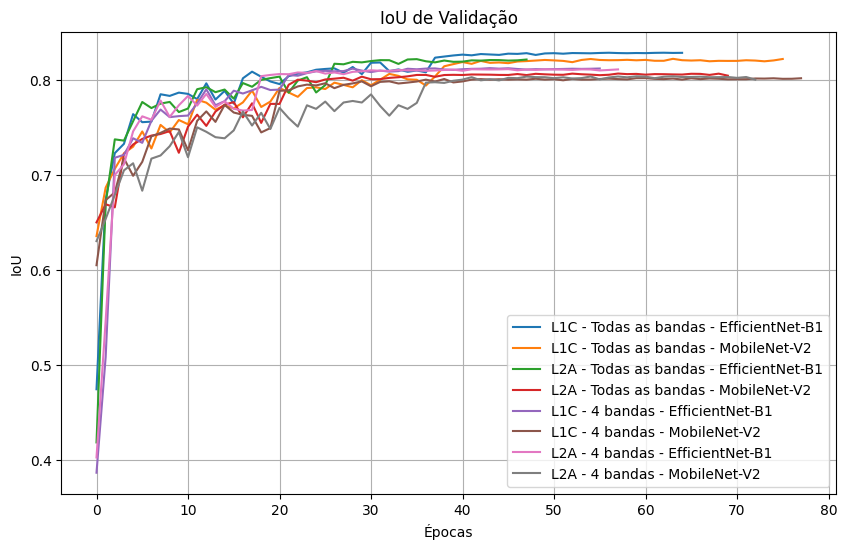

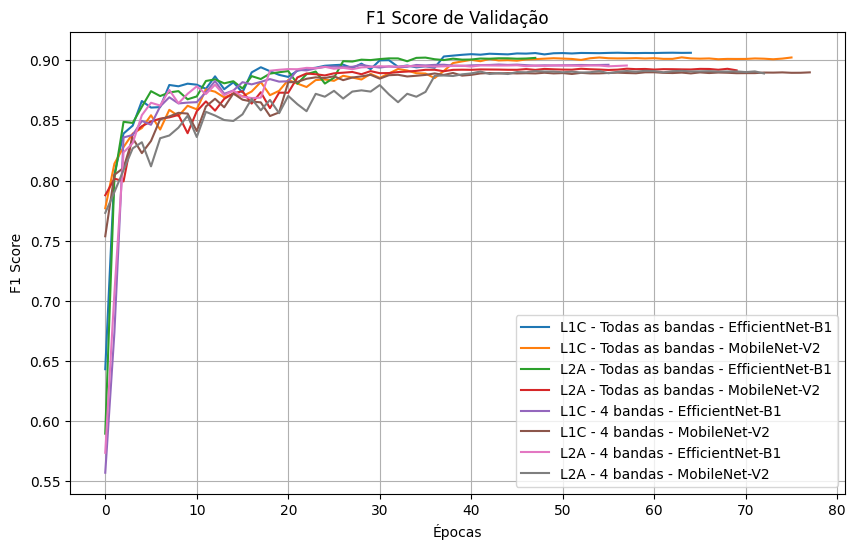

In [ ]:
# Caminhos dos logs dos modelos
model_paths = {
    "L1C - Todas as bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
    "L1C - Todas as bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
    "L2A - Todas as bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0",
    "L2A - Todas as bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0",
    "L1C - 4 bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
    "L1C - 4 bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
    "L2A - 4 bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0",
    "L2A - 4 bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0",
}

# Métricas disponíveis
metrics = {
    "train_loss": "train_loss_epoch.csv",
    "train_accuracy": "train_acuracia.csv",
    "train_iou": "train_dataset_iou.csv",
    "train_f1": "train_f1_score.csv",
    "val_loss": "val_loss.csv",
    "val_accuracy": "val_acuracia.csv",
    "val_iou": "val_dataset_iou.csv",
    "val_f1": "val_f1_score.csv",
}

# Função para carregar os dados corretamente
def load_metric(model_name, metric_name):
    file_path = os.path.join(model_paths[model_name], "train", metrics[metric_name])
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df["index"], df["value"]  # Retorna index (épocas) e value (valores da métrica)
    else:
        print(f"Arquivo não encontrado: {file_path}")
        return None, None

# Função para plotar as métricas corretamente
def plot_metrics(metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))

    for model_name in model_paths.keys():
        epochs, values = load_metric(model_name, metric_name)
        if epochs is not None and values is not None:
            plt.plot(epochs, values, label=model_name)

    plt.xlabel("Épocas")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plotando todas as métricas
plot_metrics("train_loss", "Loss de Treinamento", "Loss")
plot_metrics("train_accuracy", "Acurácia de Treinamento", "Acurácia")
plot_metrics("train_iou", "IoU de Treinamento", "IoU")
plot_metrics("train_f1", "F1 Score de Treinamento", "F1 Score")

plot_metrics("val_loss", "Loss de Validação", "Loss")
plot_metrics("val_accuracy", "Acurácia de Validação", "Acurácia")
plot_metrics("val_iou", "IoU de Validação", "IoU")
plot_metrics("val_f1", "F1 Score de Validação", "F1 Score")


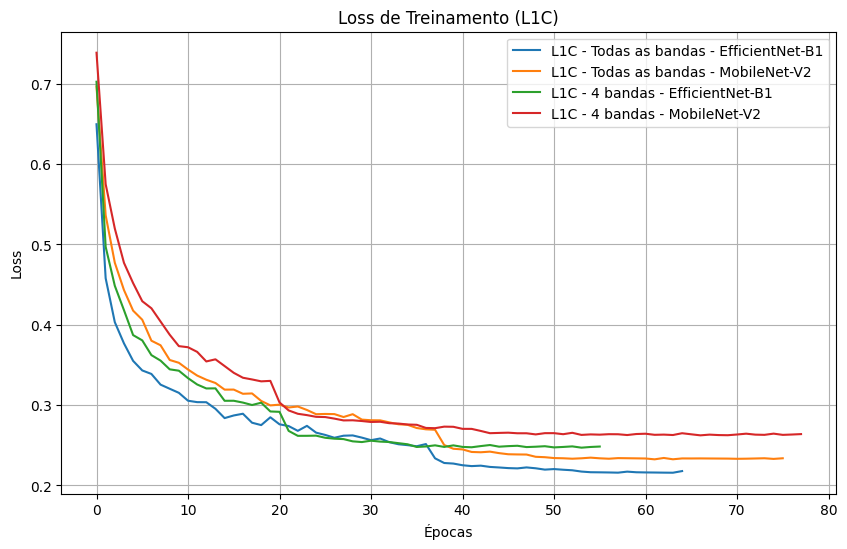

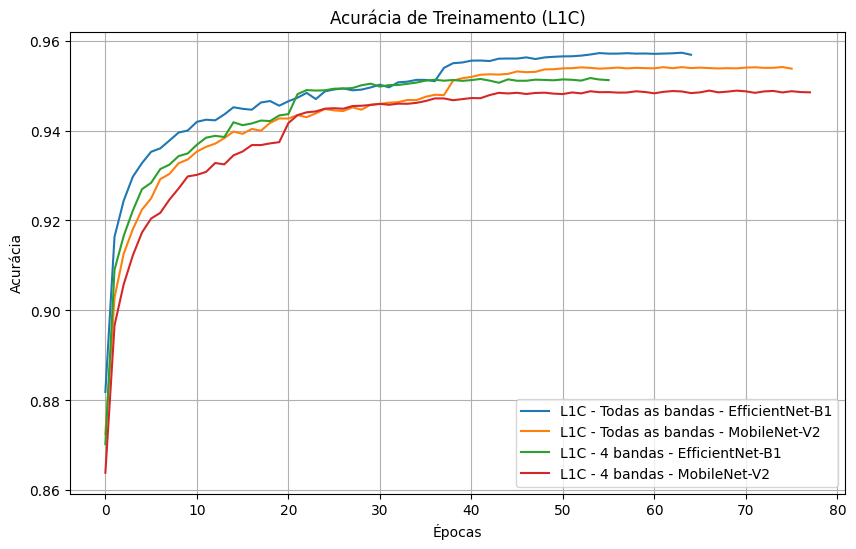

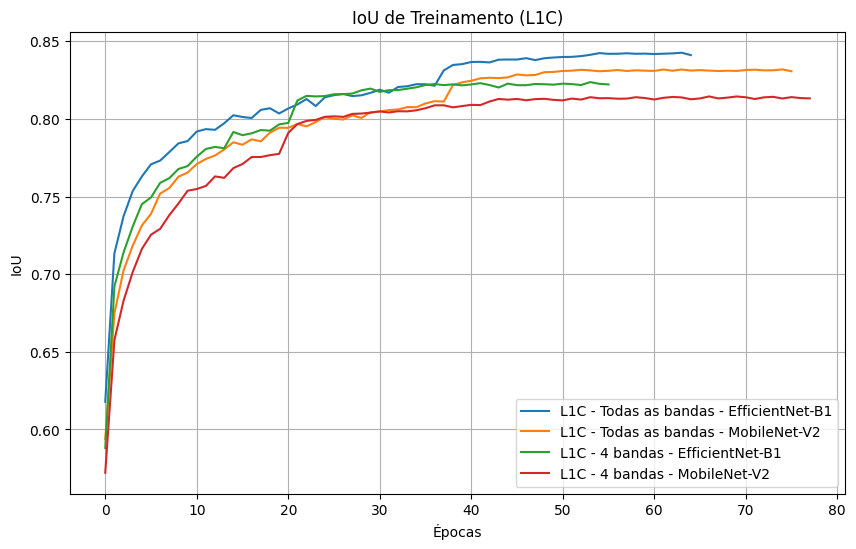

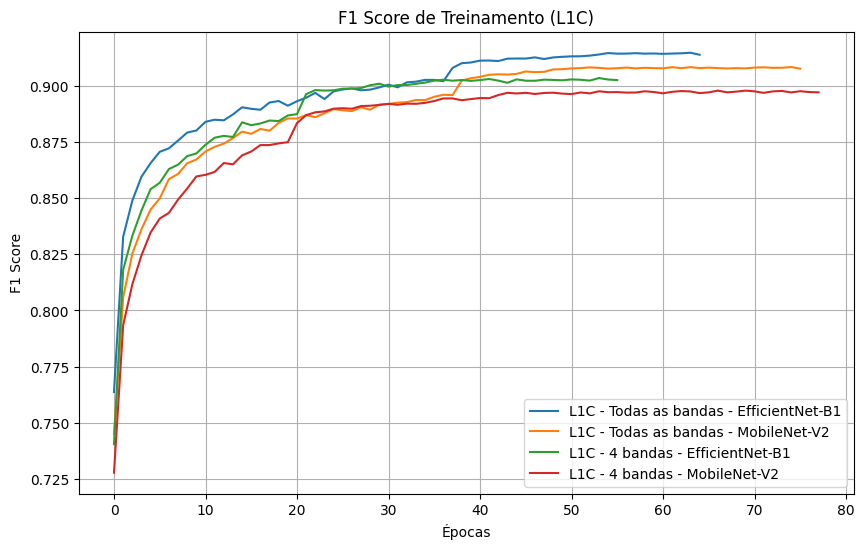

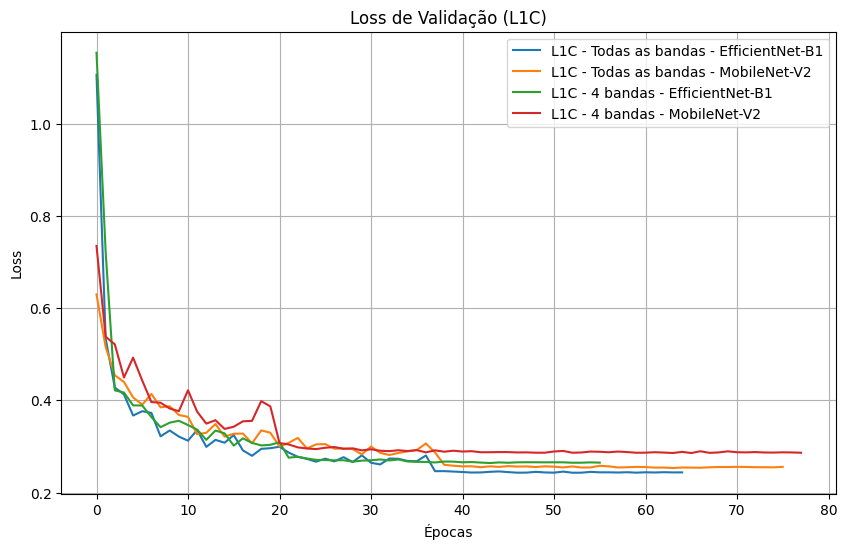

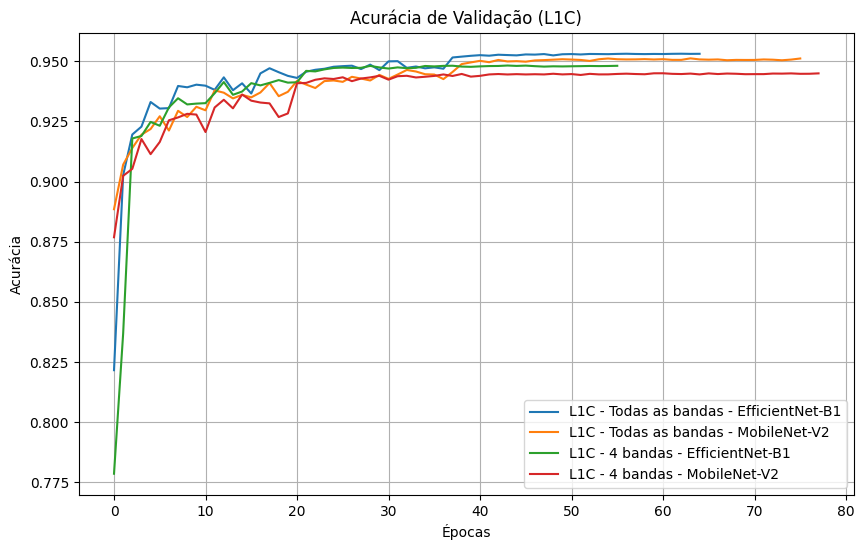

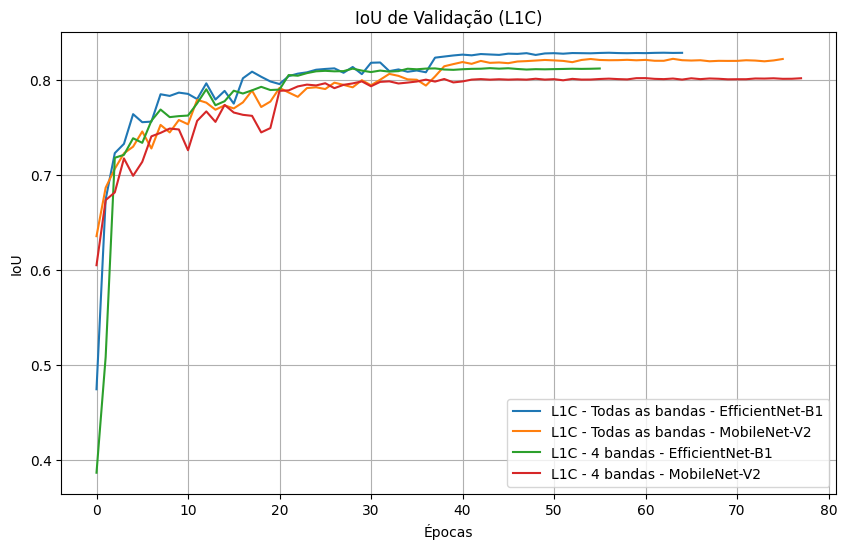

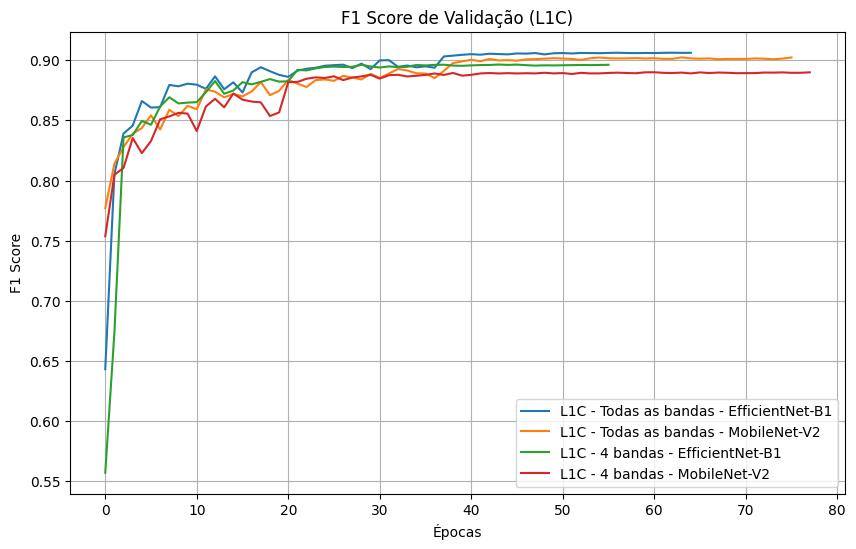

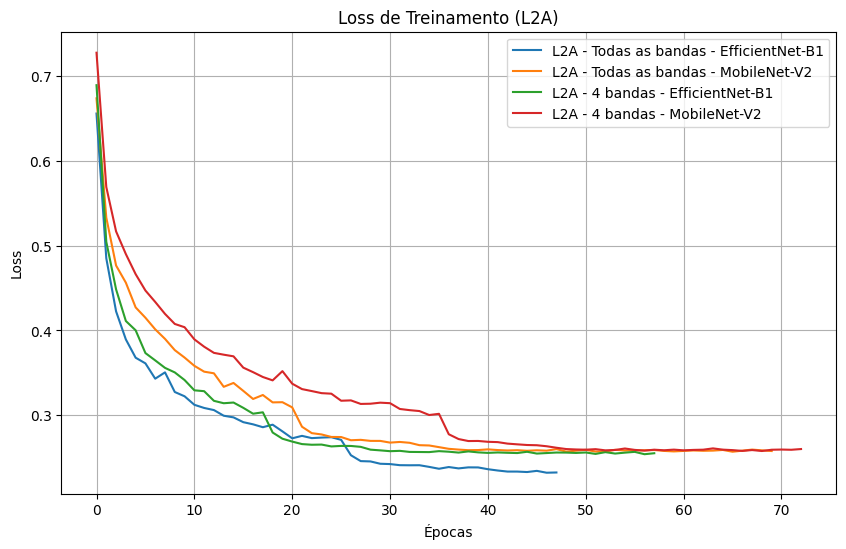

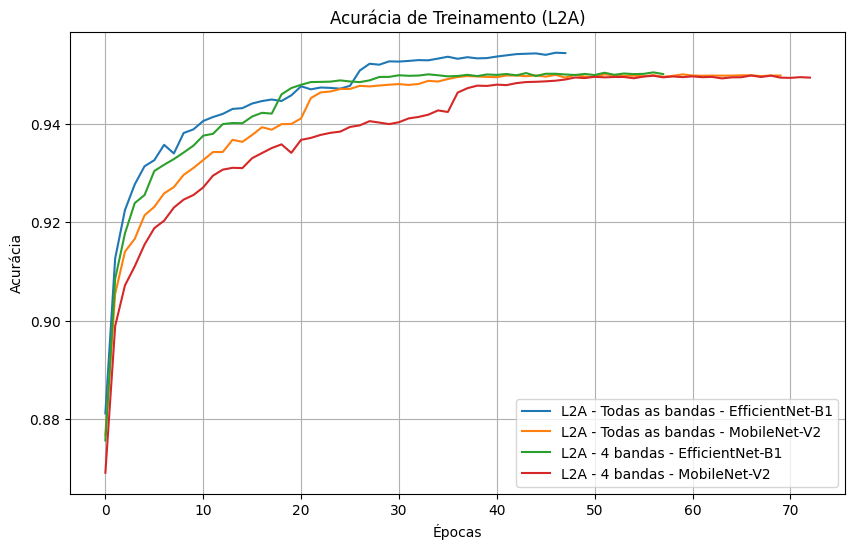

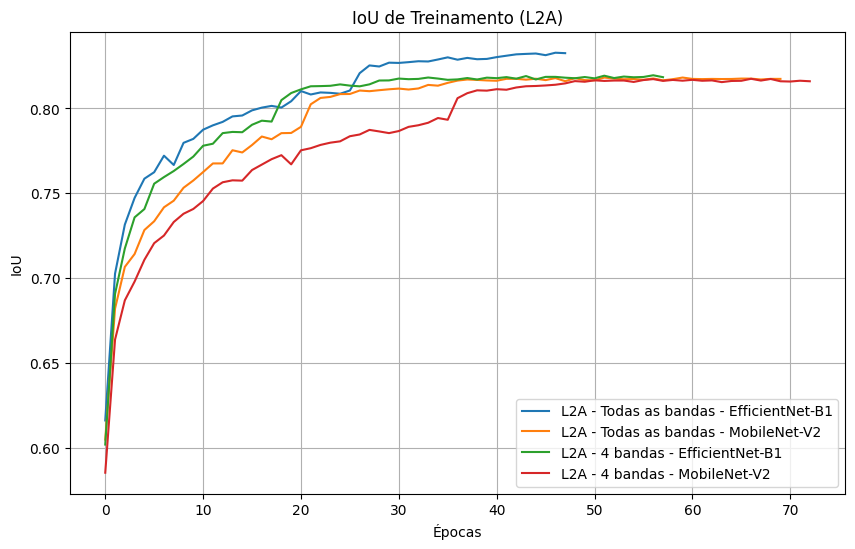

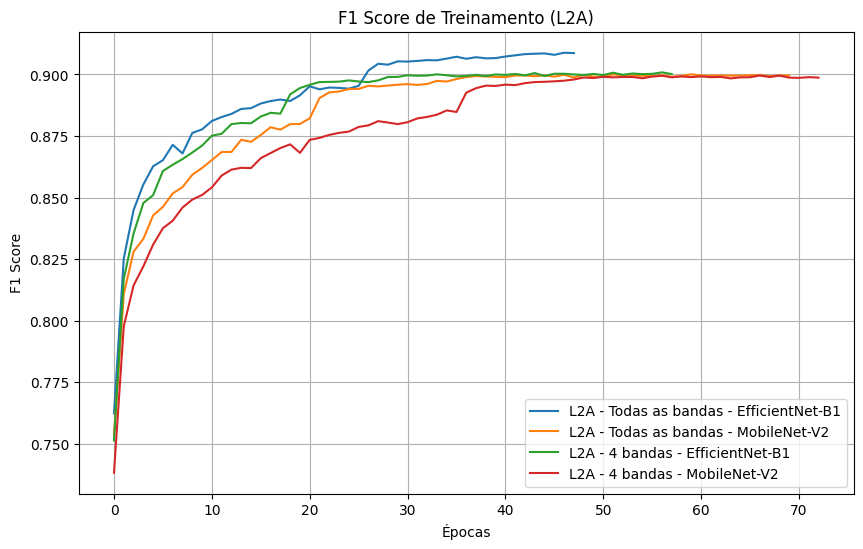

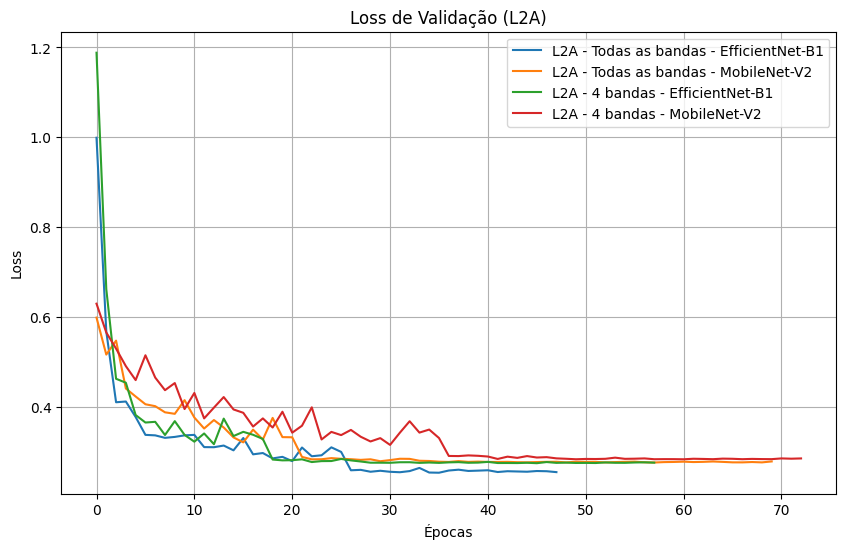

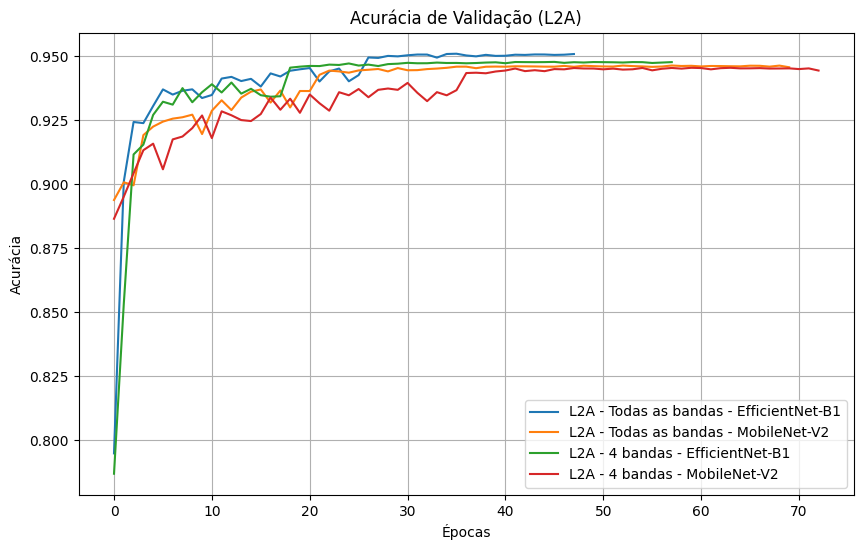

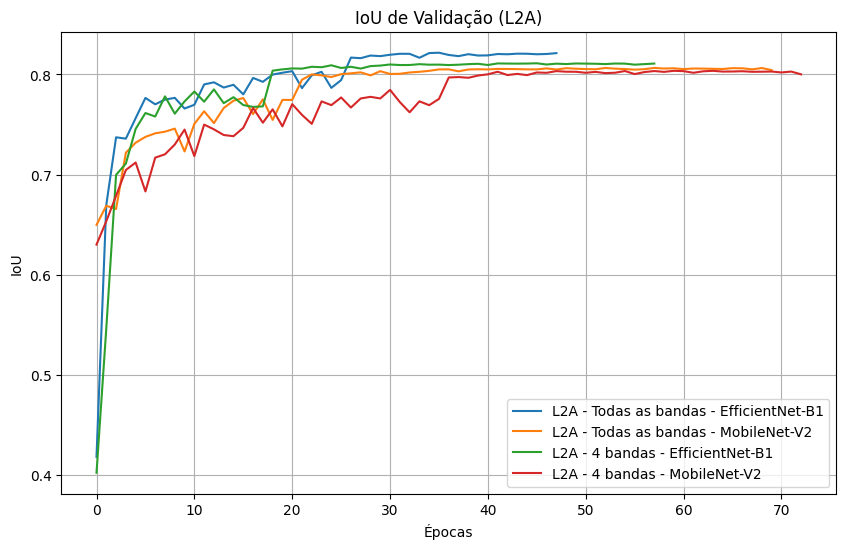

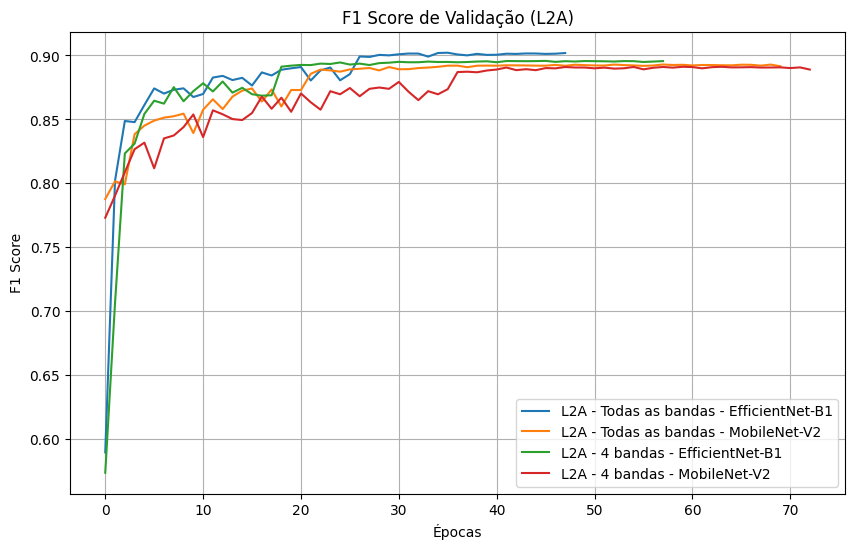

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Separação dos modelos por tipo de imagem (L1C e L2A)
models_l1c = {
    "L1C - Todas as bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
    "L1C - Todas as bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
    "L1C - 4 bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
    "L1C - 4 bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
}

models_l2a = {
    "L2A - Todas as bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0",
    "L2A - Todas as bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0",
    "L2A - 4 bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0",
    "L2A - 4 bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0",
}

# Métricas disponíveis
metrics = {
    "train_loss": "train_loss_epoch.csv",
    "train_accuracy": "train_acuracia.csv",
    "train_iou": "train_dataset_iou.csv",
    "train_f1": "train_f1_score.csv",
    "val_loss": "val_loss.csv",
    "val_accuracy": "val_acuracia.csv",
    "val_iou": "val_dataset_iou.csv",
    "val_f1": "val_f1_score.csv",
}

# Função para carregar os dados corretamente
def load_metric(model_name, model_path, metric_name):
    file_path = os.path.join(model_path, "train", metrics[metric_name])
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df["index"], df["value"]  # Retorna index (épocas) e value (valores da métrica)
    else:
        print(f"Arquivo não encontrado: {file_path}")
        return None, None

# Função para plotar as métricas corretamente
def plot_metrics(models, metric_name, title, ylabel, dataset_name):
    plt.figure(figsize=(10, 6))

    for model_name, model_path in models.items():
        epochs, values = load_metric(model_name, model_path, metric_name)
        if epochs is not None and values is not None:
            plt.plot(epochs, values, label=model_name)

    plt.xlabel("Épocas")
    plt.ylabel(ylabel)
    plt.title(f"{title} ({dataset_name})")
    plt.legend()
    plt.grid()
    plt.show()

# Gerar gráficos separadamente para L1C e L2A
datasets = [("L1C", models_l1c), ("L2A", models_l2a)]

for dataset_name, models in datasets:
    plot_metrics(models, "train_loss", "Loss de Treinamento", "Loss", dataset_name)
    plot_metrics(models, "train_accuracy", "Acurácia de Treinamento", "Acurácia", dataset_name)
    plot_metrics(models, "train_iou", "IoU de Treinamento", "IoU", dataset_name)
    plot_metrics(models, "train_f1", "F1 Score de Treinamento", "F1 Score", dataset_name)

    plot_metrics(models, "val_loss", "Loss de Validação", "Loss", dataset_name)
    plot_metrics(models, "val_accuracy", "Acurácia de Validação", "Acurácia", dataset_name)
    plot_metrics(models, "val_iou", "IoU de Validação", "IoU", dataset_name)
    plot_metrics(models, "val_f1", "F1 Score de Validação", "F1 Score", dataset_name)


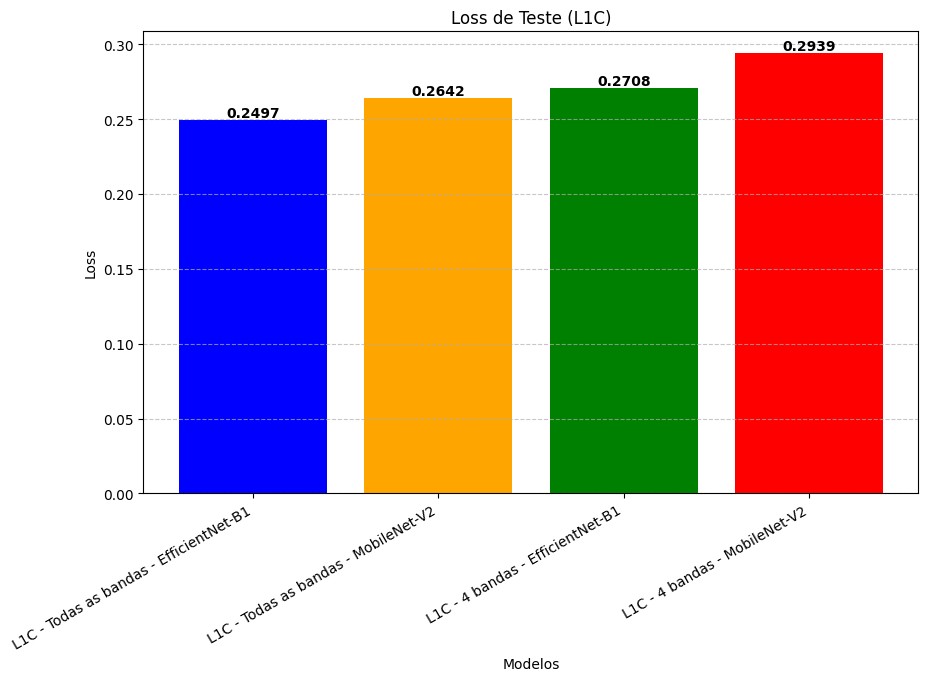

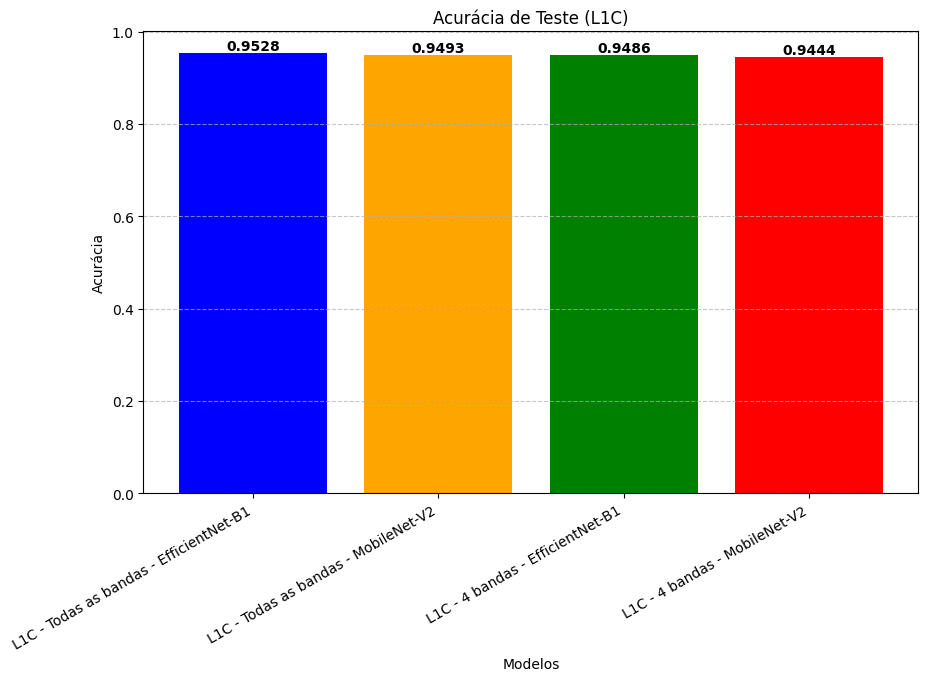

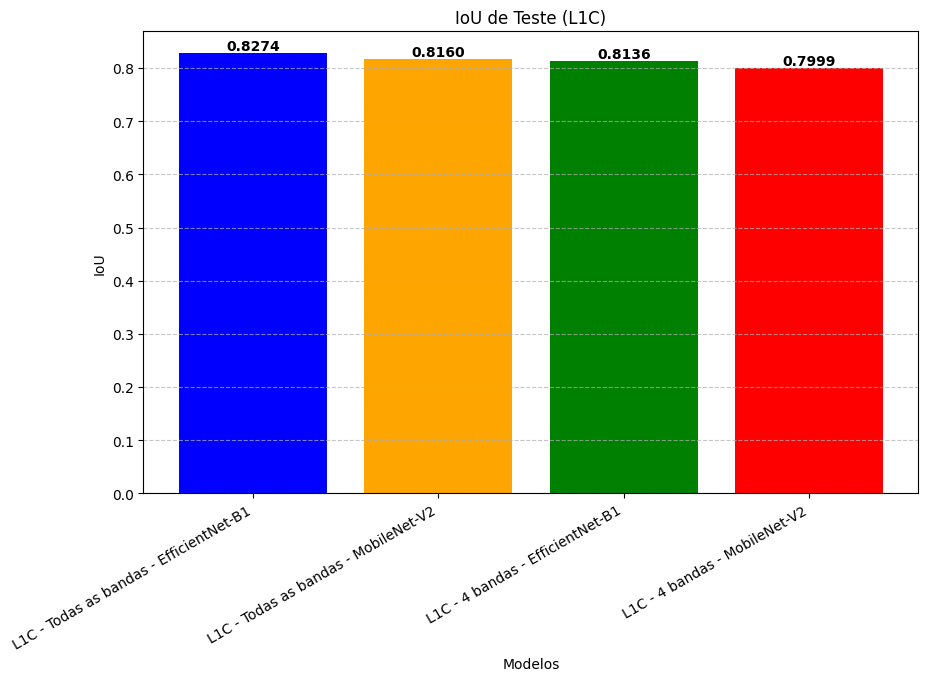

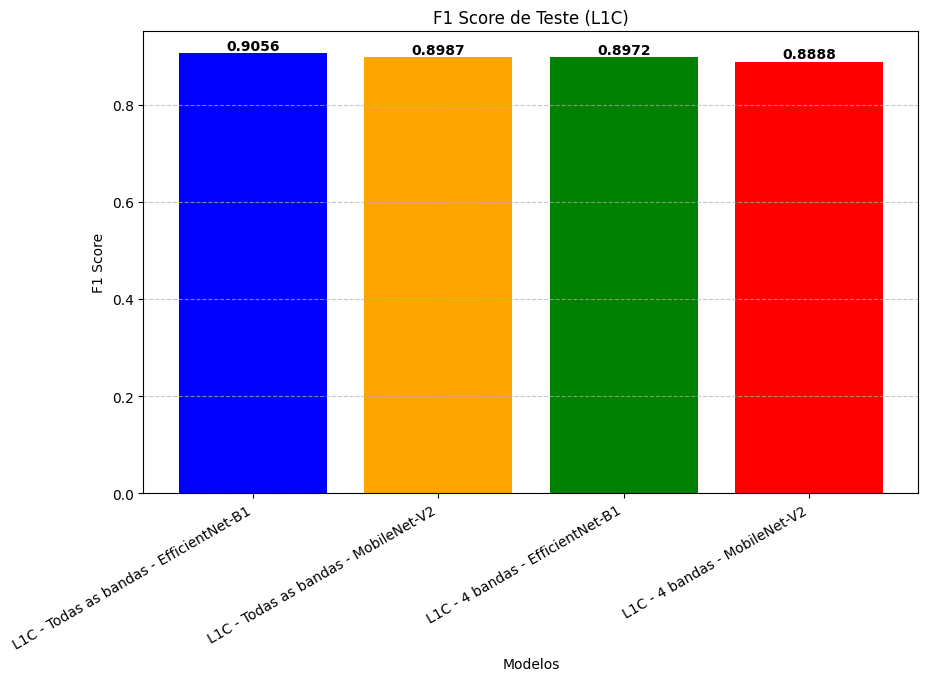

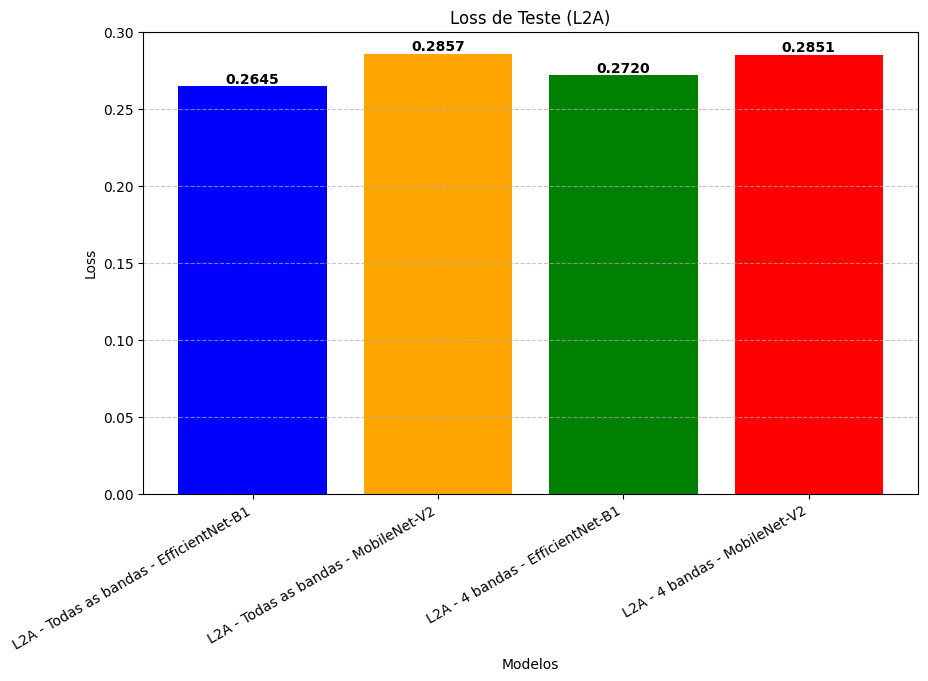

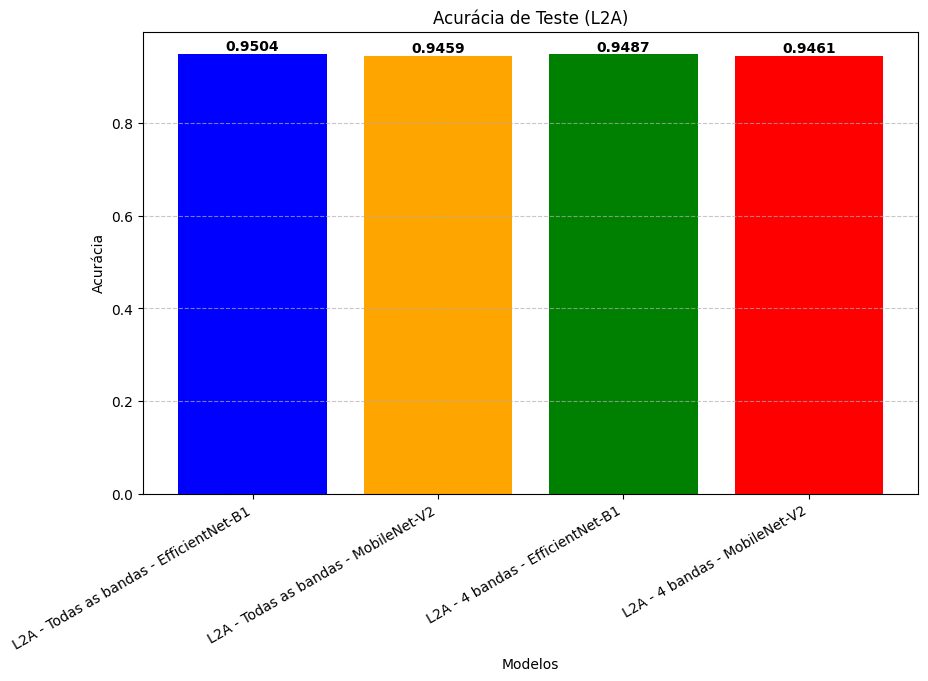

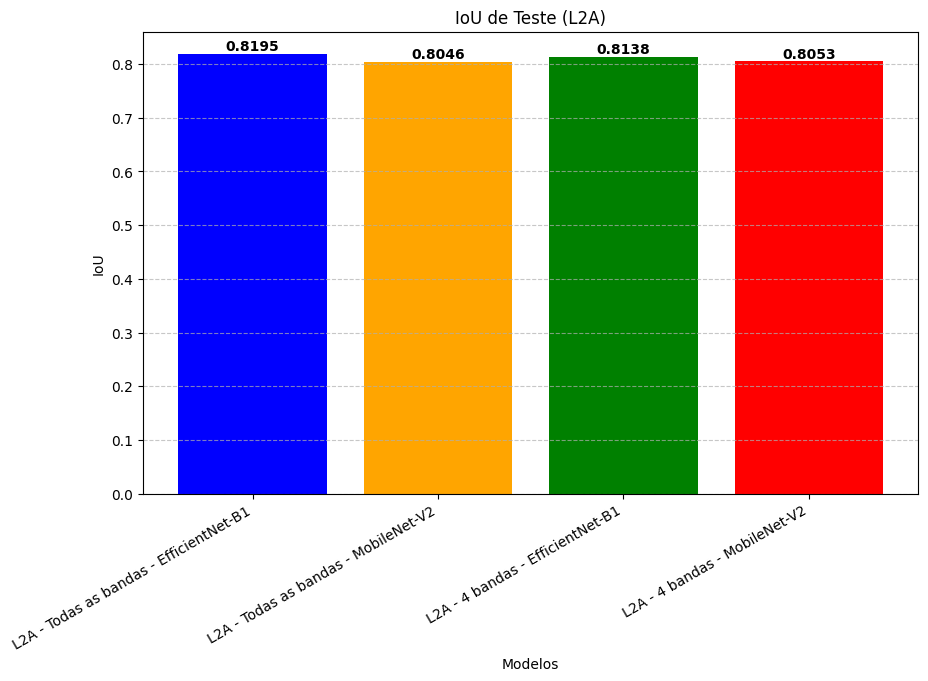

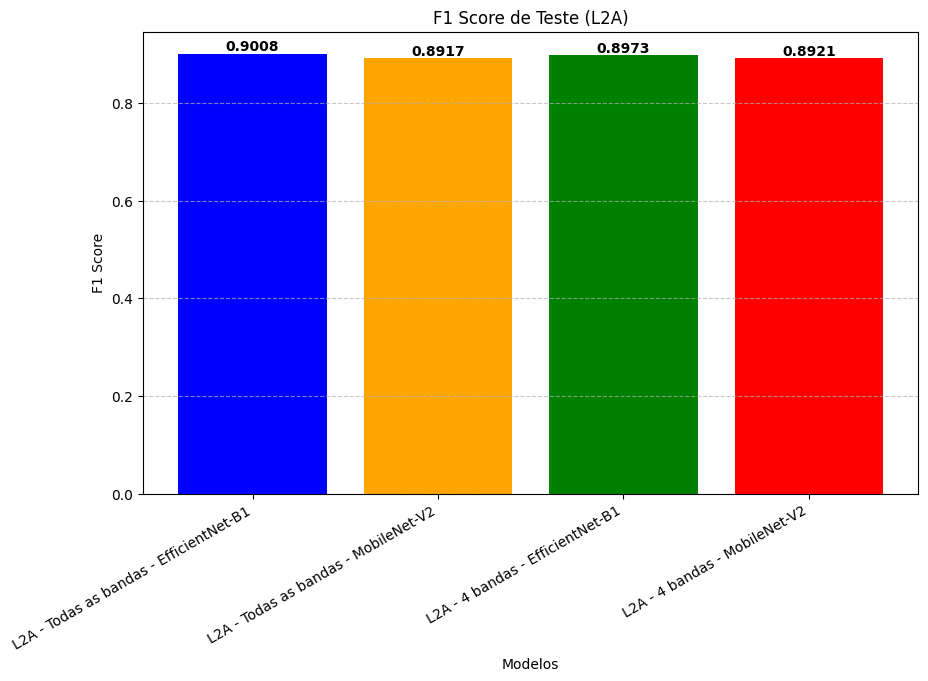

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Diretórios dos modelos organizados por conjunto de imagens
models_l1c = {
    "L1C - Todas as bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
    "L1C - Todas as bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
    "L1C - 4 bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
    "L1C - 4 bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
}

models_l2a = {
    "L2A - Todas as bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0",
    "L2A - Todas as bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0",
    "L2A - 4 bandas - EfficientNet-B1": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0",
    "L2A - 4 bandas - MobileNet-V2": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0",
}

# Métricas de teste disponíveis
test_metrics = {
    "test_loss": "test_loss.csv",
    "test_accuracy": "test_acuracia.csv",
    "test_iou": "test_dataset_iou.csv",
    "test_f1": "test_f1_score.csv",
}

# Função para carregar o valor da métrica de teste
def load_test_metric(model_path, metric_name):
    file_path = os.path.join(model_path, "test", test_metrics[metric_name])
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df["value"].values[0]  # Como é um valor único, pegamos o primeiro valor
    else:
        print(f"Arquivo não encontrado: {file_path}")
        return None

# Função para plotar gráfico de barras para métricas de teste
def plot_test_metrics(models, metric_name, title, ylabel, dataset_name):
    model_names = list(models.keys())
    values = [load_test_metric(models[name], metric_name) for name in model_names]

    # Criando o gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, values, color=["blue", "orange", "green", "red"])

    # Adicionando os valores no topo das barras
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.4f}",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel("Modelos")
    plt.ylabel(ylabel)
    plt.title(f"{title} ({dataset_name})")
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Gerar gráficos de teste separadamente para L1C e L2A
datasets = [("L1C", models_l1c), ("L2A", models_l2a)]

for dataset_name, models in datasets:
    plot_test_metrics(models, "test_loss", "Loss de Teste", "Loss", dataset_name)
    plot_test_metrics(models, "test_accuracy", "Acurácia de Teste", "Acurácia", dataset_name)
    plot_test_metrics(models, "test_iou", "IoU de Teste", "IoU", dataset_name)
    plot_test_metrics(models, "test_f1", "F1 Score de Teste", "F1 Score", dataset_name)


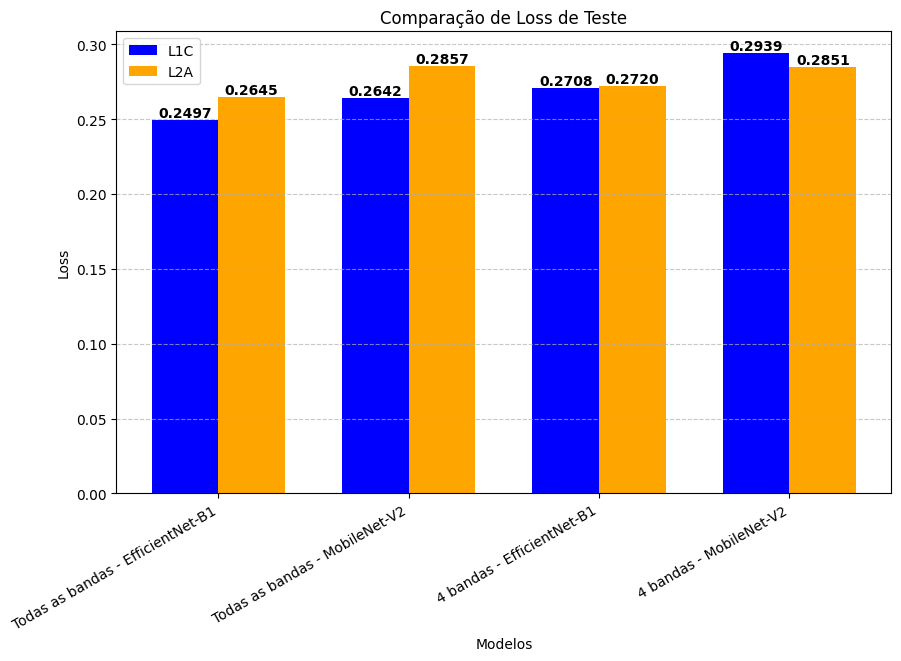

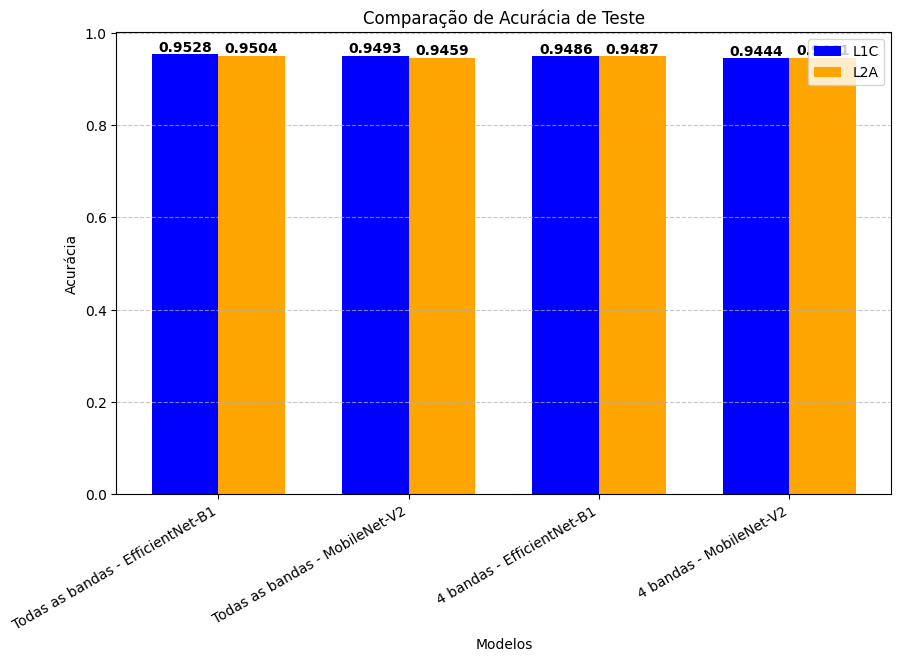

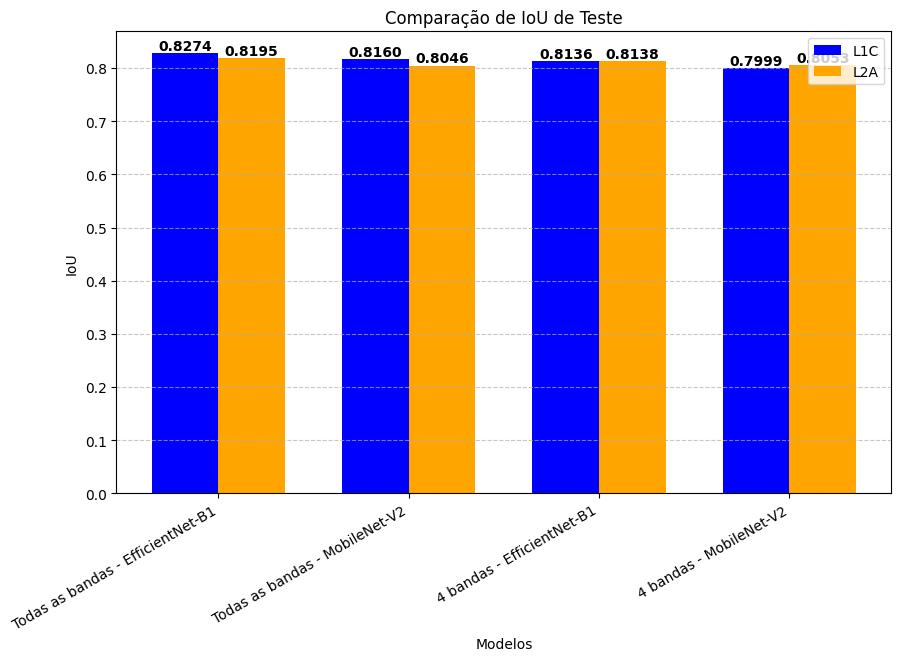

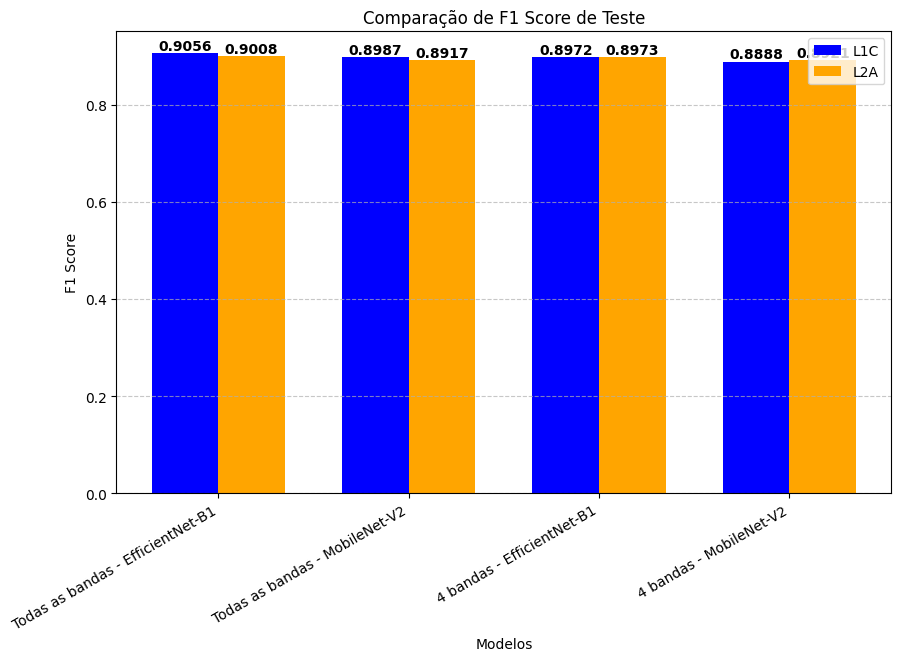

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Diretórios dos modelos organizados por encoder e quantidade de bandas
models = {
    "Todas as bandas - EfficientNet-B1": {
        "L1C": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
        "L2A": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0"
    },
    "Todas as bandas - MobileNet-V2": {
        "L1C": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
        "L2A": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0"
    },
    "4 bandas - EfficientNet-B1": {
        "L1C": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
        "L2A": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0"
    },
    "4 bandas - MobileNet-V2": {
        "L1C": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
        "L2A": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0"
    },
}

# Métricas de teste disponíveis
test_metrics = {
    "test_loss": "test_loss.csv",
    "test_accuracy": "test_acuracia.csv",
    "test_iou": "test_dataset_iou.csv",
    "test_f1": "test_f1_score.csv",
}

# Função para carregar o valor da métrica de teste
def load_test_metric(model_path, metric_name):
    file_path = os.path.join(model_path, "test", test_metrics[metric_name])
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df["value"].values[0]  # Pegamos o único valor disponível
    else:
        print(f"Arquivo não encontrado: {file_path}")
        return None

# Função para plotar gráfico de barras comparando L1C e L2A
def plot_comparison(metric_name, title, ylabel):
    model_names = list(models.keys())
    l1c_values = [load_test_metric(models[name]["L1C"], metric_name) for name in model_names]
    l2a_values = [load_test_metric(models[name]["L2A"], metric_name) for name in model_names]

    x = np.arange(len(model_names))  # Posições no eixo X
    width = 0.35  # Largura das barras

    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(x - width/2, l1c_values, width, label="L1C", color="blue")
    bars2 = plt.bar(x + width/2, l2a_values, width, label="L2A", color="orange")

    # Adicionando os valores no topo das barras
    for bar, value in zip(bars1, l1c_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.4f}",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    for bar, value in zip(bars2, l2a_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.4f}",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel("Modelos")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x, model_names, rotation=30, ha="right")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Gerar gráficos para cada métrica comparando L1C e L2A
plot_comparison("test_loss", "Comparação de Loss de Teste", "Loss")
plot_comparison("test_accuracy", "Comparação de Acurácia de Teste", "Acurácia")
plot_comparison("test_iou", "Comparação de IoU de Teste", "IoU")
plot_comparison("test_f1", "Comparação de F1 Score de Teste", "F1 Score")


In [ ]:
import os
import pandas as pd

# Definição dos modelos
data = []

models = {
    "Todas as bandas - EfficientNet-B1": {
        "L1C": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
        "L2A": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0"
    },
    "Todas as bandas - MobileNet-V2": {
        "L1C": "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
        "L2A": "/content/drive/MyDrive/Unet_all_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0"
    },
    "4 bandas - EfficientNet-B1": {
        "L1C": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_efficientnet-b1/version_0",
        "L2A": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_efficientnet-b1/version_0"
    },
    "4 bandas - MobileNet-V2": {
        "L1C": "/content/drive/MyDrive/Unet_4_bands_l1c/lightning_logs/Unet_mobilenet_v2/version_0",
        "L2A": "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_mobilenet_v2/version_0"
    }
}

# Definição das métricas de teste
test_metrics = {
    "Acurácia": "test_acuracia.csv",
    "IoU": "test_dataset_iou.csv",
    "F1-Score": "test_f1_score.csv",
}

def load_test_metric(model_path, metric_name):
    file_path = os.path.join(model_path, "test", test_metrics[metric_name])
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df["value"].values[0]  # Pegamos o único valor disponível
    else:
        return None

# Organizando os dados no DataFrame
data = []
for model_name, paths in models.items():
    row = {"Modelo": model_name}
    for level in ["L1C", "L2A"]:
        for metric in test_metrics:
            row[f"{level}_{metric}"] = load_test_metric(paths[level], metric)*100 if level in paths else None
    data.append(row)

df = pd.DataFrame(data)

# Ajustando multi-index para melhor organização
df.columns = pd.MultiIndex.from_tuples([(col.split('_')[0], col.split('_')[1]) if '_' in col else (col, '') for col in df.columns])

# Exibindo o DataFrame
df


Modelo        L1C                        \
                                       Acurácia        IoU   F1-Score   
0  Todas as bandas - EfficientNet-B1  95.278484  82.743478  90.556967   
1     Todas as bandas - MobileNet-V2  94.934696  81.602561  89.869398   
2         4 bandas - EfficientNet-B1  94.862354  81.364286  89.724708   
3            4 bandas - MobileNet-V2  94.441956  79.991937  88.883913   

         L2A                        
    Acurácia        IoU   F1-Score  
0  95.041007  81.953859  90.082020  
1  94.586152  80.460298  89.172298  
2  94.866705  81.378597  89.733410  
3  94.606429  80.526352  89.212853